In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import ppigrf
from scipy.optimize import minimize

C:\Users\freim\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
def untilt(in_array, direction = 'backward'):
    """
    Untilt X Y Z magnetic values by  pitch, roll and yaw to North East and Vertical (down) components
    Args:
        in_array (np.array): Array with data in shape (n,6) where n is the number of samples
        and columns is  ROLL, PITCH, YAW, X, Y, Z
            
        direction (str):  option to untilt or tilt the vector components (default - untilt)
               backward - to UNTILT vector values by pitch roll and yaw
               forward - to TILT vector values by pitch roll and yaw
    
    Returns:
        numpy.array with untilted North East and Vertical (down) values
    """
    out_array = np.zeros((len(in_array),3))
    
    for num, row in enumerate(in_array):
        roll = np.deg2rad(row[0])
        pitch = np.deg2rad(row[1])
        yaw = np.deg2rad(row[2])
        
        vector = row[3:]   # vector contains X,Y, Z magnetic values
        

    #roll matrix
        Mroll =np.array([[1., 0.          , 0.],
                        [0., np.cos(roll), -np.sin(roll)],
                        [0., np.sin(roll), np.cos(roll)]])
    #pitch matrix
        Mpitch =np.array([[np.cos(pitch) , 0. ,np.sin(pitch)],
                         [0.            , 1. ,0.],
                         [-np.sin(pitch), 0. ,np.cos(pitch)]])
    #yaw matrix
        Myaw=np.array([[np.cos(yaw), -np.sin(yaw),0.], 
                      [np.sin(yaw) , np.cos(yaw) ,0.],
                      [0.          , 0.          ,1.]])
        
        a=np.dot(Myaw,Mpitch)
        R=np.dot(a,Mroll)
        
        # in case you need TILT instead of UNTILT, for synthetical purposes.
        if direction == 'forward':
            R = R.transpose()
            
        #tilt the data
        v_tiltes=np.dot(R,vector)
        out_array[num] = v_tiltes
    return out_array

In [31]:
def generate_synthetic(vector_components,positional_limits,noise, misaligment, samples):
    """
    Generate set of "measured" North - East - Vertical(d) [N-E-V] magnetic values based on INS specification
    Args:
        vector_components (np.array): Array with real [N-E-V] values 
        samples (int): amount of "measurements"
        
        
    Returns:
        numpy.array with shape (samples,3) contains "measured" magnetic values
    """
    
    
    #all the following arrays have shape (samples, 3)
    initial_mag_array = np.array([vector_components for i in range(samples)])
    
    #generate normally distributed noise within the desired range
    noise_array = np.array([np.random.normal(0, att_comp_noise, size = samples) for att_comp_noise in noise]).T
    
    limits = positional_limits * 2
    limits[2] = limits[2]/2

    
    # generate attitude triplets with uniformaly distributed values within desired ranges
    pos_array = [(np.random.random(3)-0.5) * limits for i in range(samples)]
    
#     general_heading = 0
#     for ind, value in enumerate(pos_array):
#         pos_array[ind][2] += general_heading

    # generate additional static misalignment
    Euler_array = np.array( [misaligment for i in range(samples)] )
    
    #generate measured attitude triplets
    observed_array = pos_array + Euler_array + noise_array
    
    #tilt real NEV data to XYZ in bird reference frame. 
    field_array = untilt(np.hstack((pos_array,initial_mag_array)), direction = 'forward')
    
    #untilt XYZ data back to NEV using the measured attitude triplets.
    untilted_array = untilt(np.hstack((observed_array,field_array)))
    
    #return result in DataFrame type
    result = pd.DataFrame(np.hstack((observed_array,field_array,untilted_array)),
                         columns = ['pitch','roll','yaw','x','y','z','x_unt','y_unt','z_unt'])
    return result


In [14]:
#specify location where to perform theoretical measurements
lat = 32
lon = 35
Be,Bn,Bu = ppigrf.igrf(lon, lat, 0, datetime(2023,3,1))
Be = Be[0][0]
Bn = Bn[0][0]
Bd = -Bu[0][0]

vectors = [Bn, Be, Bd]
print('IGRF for location {}° N, {}° E \nNorth {} nT,\nEast {} nT, \nVertical (down) {} nT'.format(lat,lon,Bn,Be,Bd))
#specify limits for attitude in degrees. 1 - pitch, 2 - roll, 3 - yaw
pos_limits = np.array([40,40,20])
#specify precision of the INS measurements in the same order (StD, deg)
noise = np.array([0.03,0.03,0.08])
#specify misalignment between magnetometer and INS  in the same order (deg)
misaligment = [0,0,0]
#specify amount of synthetic samples
samples = 10000
data = generate_synthetic(vectors, pos_limits, noise, misaligment, samples)
data[['x_unt','y_unt','z_unt']].describe()


IGRF for location 32° N, 35° E 
North 29864.184731099256 nT,
East 2620.218061674258 nT, 
Vertical (down) 33813.20201292286 nT


,x_unt,y_unt,z_unt
count,10000.000000,10000.000000,10000.000000
mean,29864.015947,2619.909472,33813.336706
std,18.054396,44.907824,15.714902
min,29788.065727,2444.330727,33757.501605
25%,29851.863858,2589.637768,33802.879485
50%,29864.104047,2620.156774,33813.263207
75%,29876.151645,2650.545381,33823.938292
max,29931.038534,2798.357315,33877.587674


<h1>Visualisation of measured and real vector magnetic components</h1>

<IPython.core.display.Javascript object>


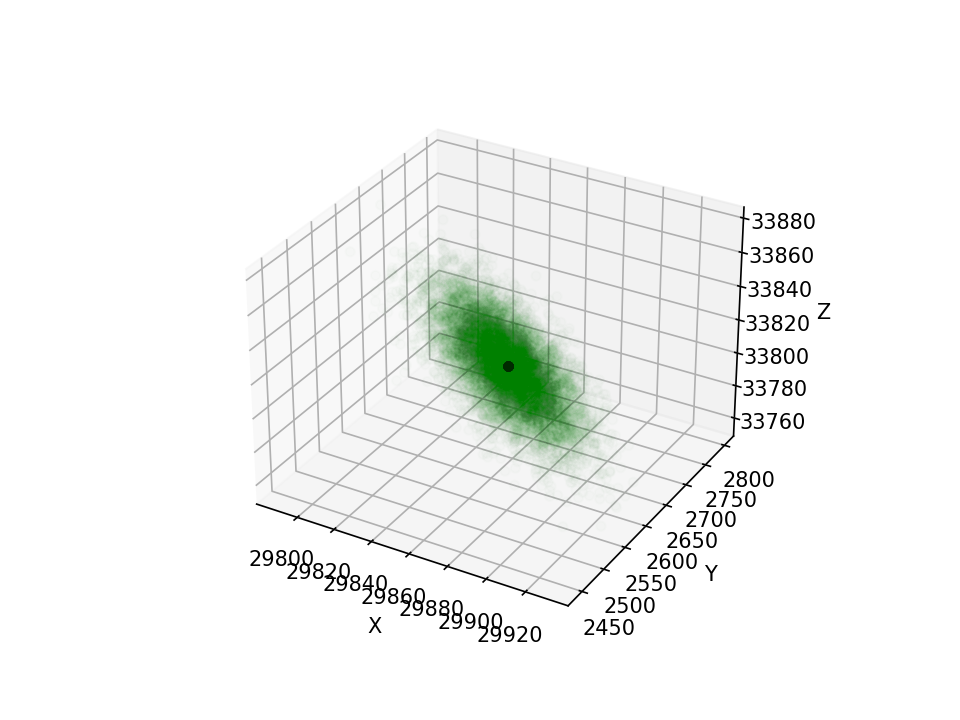

Standart deviation of vector components:


,x_unt,y_unt,z_unt
count,10000.000000,10000.000000,10000.000000
mean,29864.015947,2619.909472,33813.336706
std,18.054396,44.907824,15.714902
min,29788.065727,2444.330727,33757.501605
25%,29851.863858,2589.637768,33802.879485
50%,29864.104047,2620.156774,33813.263207
75%,29876.151645,2650.545381,33823.938292
max,29931.038534,2798.357315,33877.587674


In [24]:
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(data['x_unt'], data['y_unt'], data['z_unt'], c = 'green', alpha = 0.01)
ax.scatter(Bn,Be,Bd, c = 'red')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
print('Standart deviation of vector components:')
data[['x_unt','y_unt','z_unt']].describe()